## 0. Setup

In [1]:
import os


batch_size = 2
threads = 4

# Should point to the root folder of the cropped images, see the tutorial for preparing IXI
dataset_folder = os.path.join(os.path.expanduser('~'), 'data', 'IXI', 'cropped')

## 1. Instantiate the generator

In [3]:
from pyment.data import AsyncNiftiGenerator, NiftiDataset


dataset = NiftiDataset.from_folder(dataset_folder, target='age')

# Set up a preprocessor to normalize the voxel values
preprocessor = lambda x: x/255

generator = AsyncNiftiGenerator(dataset, preprocessor=preprocessor, 
                                batch_size=batch_size, threads=threads)

## 2. Sanity check the generator

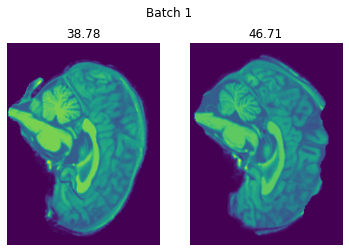

Image batch shape: (2, 167, 212, 160)
Image voxel value range: 0.0-0.78


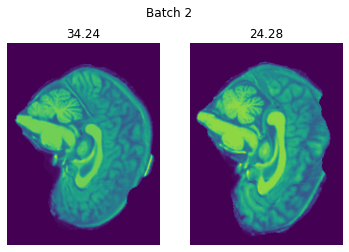

Image batch shape: (2, 167, 212, 160)
Image voxel value range: 0.0-0.61


IndexError: index 1 is out of bounds for axis 0 with size 1

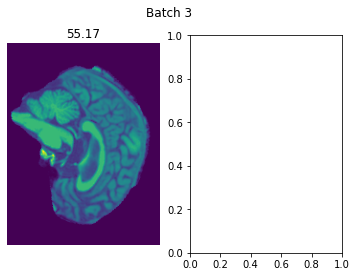

In [6]:
import matplotlib.pyplot as plt
import numpy as np

batches = 0

for X, y in generator:
    fig, ax = plt.subplots(1, batch_size)
    fig.suptitle(f'Batch {batches+1}')
    
    for i in range(batch_size):
        ax[i].imshow(X[i,83,:,:])
        ax[i].axis('off')
        ax[i].set_title(round(y[i], 2))
        
    plt.show()
    
    print(f'Image batch shape: {X.shape}')
    print(f'Image voxel value range: {round(np.amin(X), 2)}-{round(np.amax(X), 2)}')
    
    batches += 1
    
    if batches > 2:
        break

## 3. Configure the model

In [4]:
from pyment.models import RegressionSFCN


model = RegressionSFCN(weights='brain_age')

## 4. Generate predictions

In [5]:
generator.reset()

preds, labels = model.predict(generator, return_labels=True)

100%|██████████| 269/269 [17:04<00:00,  3.81s/it]


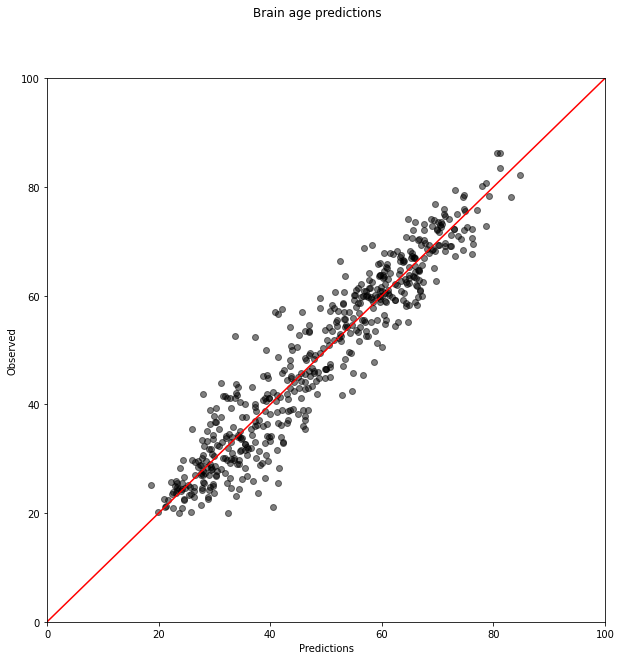

MAE: 4.0036184700555255


In [13]:
preds = preds.squeeze()
mae = np.mean(np.abs(preds - labels))
fig = plt.figure(figsize=(10, 10))
plt.scatter(preds, labels, c='black', alpha=0.5)
fig.suptitle('Brain age predictions')
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.plot([0, 100], [0, 100], c='red')
plt.xlabel('Predictions')
plt.ylabel('Observed')
plt.show()

print(f'MAE: {mae}')